In [7]:
import control
import numpy as np
from math import pi
import matplotlib.pyplot as plt

In [8]:
# very back of the napkin
target_d = 75 # m
target_v = 27.78 # m/s -- 100 km/h
target_t = 5 # s to target_v
weight = 300 # kg
tyre_r = 0.2 # m

target_a =  2*(target_d) / target_t**2
target_F = weight * target_a
target_Mt = target_F * tyre_r # force times wheel radius (277.8 Nm for 5s 0-100km/h, 300 Nm for 5s 75m)


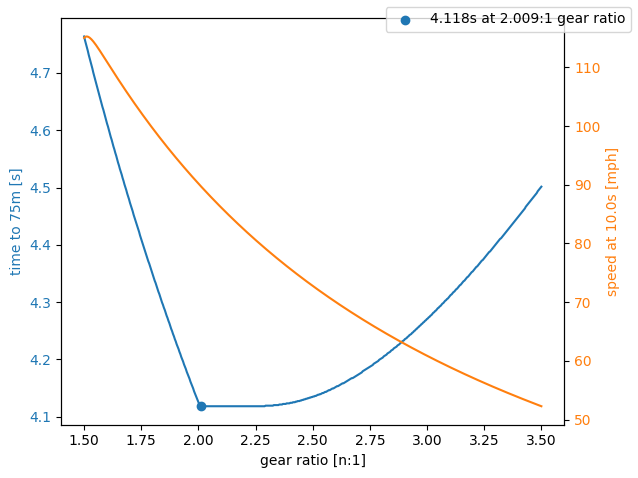

In [20]:
Kv = 1.026 # 9.8 RPM/Vdc = 1.026 rad/s/Vdc
Kt = 1.1 # Nm/Arms
R = 0.1 # 18 mOhm
Vin = 400 # Vdc
max_I = 250 # Arms
ratios = np.linspace(1.5, 3.5, 500) # gear ratio, input/output
accel_times = np.zeros(ratios.size)
top_speeds = np.zeros(ratios.size)

for j, ratio in enumerate(ratios):
    length = 10 # s
    freq = 1000 # Hz
    t = np.linspace(0, length, freq*length)
    x = np.zeros((3, freq*length)) # x = [car position [m]; car speed [m/s]; current [A]]
    y = np.zeros((3, freq*length)) # y = [ground force [N]; drag force [N]; accel [m/s^2]]

    for i in range(1, freq*length):
        motor_speed = x[1, i-1] / tyre_r * ratio
        max_It = (Vin - (motor_speed / Kv))/R
        x[2, i] = min(max_I, max_It)
        Ti = Kt*x[2, i]
        ground_force = Ti * ratio / tyre_r
        max_ground_force = 1.5*(weight*9.81/1.6) # 1.5 is guessed CoF for tyres
        if max_ground_force < ground_force:
            ground_force = max_ground_force
            Ti = ground_force * tyre_r / ratio
            x[2, i] = Ti / Kt
        drag_force = 0.5 * 1.293 * x[1, i-1]**2 * 0.73 * 1
        car_accel = (ground_force-drag_force)/weight
        x[1, i] = x[1, i-1] + car_accel * (1/freq)
        x[0, i] = x[0, i-1] + x[1, i] * (1/freq)
        y[0, i] = ground_force
        y[1, i] = drag_force
        y[2, i] = car_accel

    idx = (np.abs(x[0, :] - 75)).argmin()

    """ plt.plot(t, x[0, :])
    plt.plot(t, x[1, :] * 2.23694)
    plt.scatter(t[idx], x[0,idx])
    plt.plot(t, x[2, :] * Vin / 1000)
    plt.plot(t, Kt*x[2, :]*(x[1, :] / tyre_r * ratio)/1000)
    plt.xlabel("time [s]")
    plt.title("Gear Ratio {:.2f}:1".format(ratio))
    plt.legend(["position [m]", "speed [mph]", str(t[idx]) + "s to 75m", "input power [kW]", "mech power [kW]"])
    plt.show() """
    accel_times[j] = t[idx]
    top_speeds[j] = x[1, -1] * 2.23694

idx = accel_times.argmin()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('gear ratio [n:1]')
ax1.set_ylabel('time to 75m [s]', color=color)
ax1.plot(ratios, accel_times, color=color)
plt.scatter(ratios[idx], accel_times[idx], color=color, label="{:.3f}s at {:.3f}:1 gear ratio".format(accel_times[idx], ratios[idx]))
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('speed at {:.1f}s [mph]'.format(length), color=color)  # we already handled the x-label with ax1
ax2.plot(ratios, top_speeds, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend()
plt.show()